Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 07: Compression

## Introduction

This week's sheet should be solved and handed in before the end of **Monday, January 13, 2025**. If you need help (and Google and other resources were not enough), feel free to use the StudIP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Redundancy and compression (5 points)

**a)** Explain in your own words the different types of redundancy mentioned on (CV-08 slide 55). How can you check for each of these types of redundancy?

* Coding Redundancy (bits for coding gray values): m < n codes are needed (n = codes that represent information)
* interpixel redundancy (data points per pixel)
* psychovisual redundancy (information required fore recognition)

**b)** Explain the differences between lossless and lossy compression. Name examples for both of them.

lossless Compression:
* Reduces file size without losing any data
* original data perfectly reconstructacble from the compressed file

Lossy Compression: 
* Reduces file size by permanently removing some data
* usually data that seems less important or imperceptible to human senses

**c)** Compare photos of a scenery to company or product logos that can often be found on websites. Describe their features and explain which type of compression should be used for either.

Scenery
* features: complex and detailed scenery, many colors, textures and objects
* Lossy -> balance between file size and visual quality, small reductions in detail and color felity often imperceptible


Logos:
* fetures: simple and clean design, few details, sharp edges
* Lossless -> maintain sharpness adn clarity, no qualitiy loss

## Assignment 2: Entropy based compression (8 points)

**a)** Explain the idea of Huffman coding. What is the maximal compression factor that can be achieved for a given image? Load an image and compute that value (you may use `dolly.png` as an example. Make sure to load as 8-bit gray scale image).

Huffmann coding is used to compress data by reducing the number of bits needed to store information but without losing important details of the image. Meaning that Huffmann coding is a lossless compression technique. It sorts the frequency of the data values and combines the lower frequencies step-by-step.
The maximal compression factor is limited by the entropy of the image since this is the value needed to efficiently represent each pixel value with average information.

In [18]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import os
from PIL import Image



img = imageio.imread('images/images/dolly.png', pilmode='L')

# Verify image data type
print(f"Image dtype: {img.dtype}")  # Should show 'uint8'

# Flatten the image array to get all pixel values
pixel_values = img.flatten()

# Compute histogram to count pixel occurrences (256 bins for 8-bit grayscale)
histogram, _ = np.histogram(pixel_values, bins=256, range=(0, 256))

# Normalize to get probabilities
total_pixels = pixel_values.size
probabilities = histogram / total_pixels

# Compute entropy (excluding zero probabilities)
entropy = -np.sum(probabilities[probabilities > 0] * np.log2(probabilities[probabilities > 0]))

# Calculate maximal compression factor
compression_factor = 8 / entropy

# Display results
print(f"Entropy of the image: {entropy:.2f} bits per pixel")
print(f"Maximal compression factor: {compression_factor:.2f}")

Image dtype: uint8
Entropy of the image: 7.43 bits per pixel
Maximal compression factor: 1.08


**b)** Now compute the relative frequencies (normalized histogram) of the image and generate an (approximately) balanced tree, as described in (CV-08 slide 33). *Hint:* you may use Python tuples as building blocks of a tree. Every non-leaf node is a pair `(left, right)` where `left` and `right` are the left and right subtrees, respectively (of course you are free to choose another approach if you prefer to do so).

Relative Frequencies (first 10 values): [8.33333333e-06 4.58333333e-05 1.41666667e-04 1.37916667e-03
 8.80416667e-03 1.58895833e-02 1.39833333e-02 1.04062500e-02
 8.09583333e-03 7.75208333e-03]


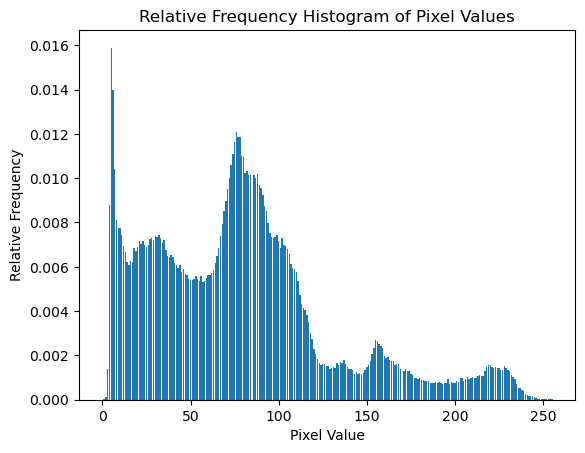

In [3]:
# Display the relative frequencies (first 10 values)
print(f"Relative Frequencies (first 10 values): {probabilities[:10]}")

# Plot the histogram of relative frequencies
plt.bar(range(256), probabilities)
plt.title("Relative Frequency Histogram of Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Relative Frequency")
plt.show()

In [4]:
# YOUR CODE HERE
raise NotImplementedError()
print(tree)

NameError: name 'tree' is not defined

**c)** Now create a prefix free code from this tree, by traversing it following the idea sketched in (CV-08 slide 34). *Hint:* if you used the tuple representation recommended in (b), you can use `isinstance(node, tuple)` to check if `node` is an inner node or a leaf.

In [ ]:
# initialize a list of code values
codes = list(normed_hist_img)

# function to recursively traverse the tree.
# For every inner node assign prefix "0" to the left subtree
# and prefix "1" to the right subtree.
def assign_codes(codes, tree, prefix=''):
    # YOUR CODE HERE
    raise NotImplementedError()

assign_codes(codes, tree.subtree)
for i, code in enumerate(codes):
    print(i, code, normed_hist_img[i])

**d)** Compute the compression ratio that you can achieve with that code. Compare this with the maximal value computed in part (a). Explain your observation.

Entropy: 7.426528842411382
Required memory: 7.459725000000001
Entropy: 7.426528842411382
Required memory: 6.459725000000001


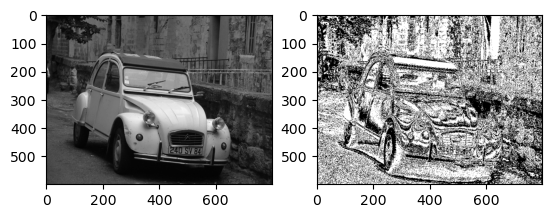

In [25]:
def entropy(frame):
    '''
    Returns the entropy of a frame (0 to 8).
    '''
    hist, _ = np.histogram(frame, range(256))
    prob = hist/frame.size
    return -(prob * np.log2(prob + 1e-8)).sum()



def huffman_coding(frame, i_max=255):
    '''
    Performs Huffman coding. Iteratively merges least likely gray values until 
    termination condition met. Then, huffman 'code' is calculated and the least 'required memory' 
    according to huffman coding.
    '''
    frame_new = np.array(frame.copy(), dtype=int)
    order = []
    for _ in range(i_max):
        hist, _ = np.histogram(frame_new, np.arange(257))
        if len(set(hist)) == 2: # break if only visited values last value remain
            break
        hist[hist==0] = frame.size
        min_gray_val = np.argmin(hist)
        hist[hist==np.min(hist)] =  frame.size
        next_min_gray_val = np.argmin(hist)
        frame_new = np.where(frame_new==min_gray_val, next_min_gray_val, frame_new)
        order.append((min_gray_val, next_min_gray_val))

    code = {i: "" for i in range(256)}

    for min_gray_val, next_min_gray_val in reversed(order):
        # print("min", min_gray_val)
        # print("next_min", next_min_gray_val)
        code[min_gray_val] = code[next_min_gray_val] + "0"
        code[next_min_gray_val] = code[next_min_gray_val] + "1"
        # for k, val in code.items(): 
        #     if val=="":
        #         continue
        #     print(k,val)
        # print("\n")
    
    required_memory = 0
    hist, _ = np.histogram(frame, np.arange(257))
    prob = hist/frame.size

    for i, x in enumerate(prob):
        bit_code = code[i]
        # print(bit_code)
        # print(f"{x}")
        required_memory += len(bit_code)*x

    print(f"Entropy: {entropy(frame)}")
    print(f"Required memory: {required_memory}")

    return frame_new, code

img = Image.open(os.path.join(os.path.abspath(""), "images", "images", "dolly.png"))
img = np.array(img)
huff, code = huffman_coding(frame=img)
# huff = cv2.erode(np.array(huff, dtype="uint8"), np.ones(9).reshape(3,3))
# huff = local_operator(frame=huff.reshape(*img.shape, 1), kernel_size=(3,3), function=lambda x: x.min())
# huff = cv2.filter2D(np.array(huff, dtype="uint8").reshape(*img.shape, 1), kernel=np.ones(25).reshape(5,5)/25, ddepth=-1)

fig, axes = plt.subplots(1,2)
axes[0].imshow(img, cmap="gray")
axes[1].imshow(huffman_coding(img, i_max=252)[0], cmap="gray")

YOUR ANSWER HERE

## Assignment 3: Run length encoding (7 points)


**a)** Explain the idea of *run length encoding*. What are advantages and disadvantages? In what situations should it be applied?

Run length coding removes redundancy caused from identical gray / colour values of neigbouring pixels
disadvantage: in the worst case, the amount of data is doubled, inefficient for noisy images as runs are very short
advantage: in best case its halfed, minimises coding redudancies 

**b)** Analyze the run lengths in a gray scale image (8 bit = 256 gray values) by counting the number of runs and the average run length and displaying a histogram of the run lengths. What do you observe? Can you benefit from run length encoding here? (you may use `dolly.png` as an example again, but you may also experiment with other images. Make sure to load it as 8-bit gray scale image).

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

# YOUR CODE HERE
raise NotImplementedError()

**c)** Now consider the individual bit planes. First display the bit planes as in (CV-08 slide 38). What do you observe? Apply your analysis from part (b) to each bitplane.

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

# YOUR CODE HERE
raise NotImplementedError()

**d)** Explain the idea of the *Gray code*. Why is it better suited for run length encoding? Compute a Gray code for a 256 bit image and recode the image `dolly.png`. Then analyze the run lengths of the individual bit planes of the recoded image.

In Gray code two successive numbers differ by one bit at most (their hamming distance of neighbouring codewords is one). There are as many Gray codes as there are Hamiltonian cycles on corresponding hyper cube. Its better suited than lenght enocidng because itll never double the amount of data and works on noisy images just as well as on not so noisy images (not like RLE)

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

# YOUR CODE HERE
raise NotImplementedError()